In [1]:
import pandas as pd
import numpy as np
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nameisalfio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nameisalfio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nameisalfio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nameisalfio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Loading dataset

In [2]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.sample(50)

,id,keyword,location,text,target
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
1457,2100,casualty,"Massachusetts, USA",Japan had a nuke program (albeit unsuccessful)...,1
5561,7936,rainstorm,Thailand Malaysia Indonesia,Nigeria: Rainstorm Destroys 600 Houses in Yobe...,1
2514,3610,desolation,Lagos Nigeria,Isai 60:1; Psm 138:8\n Every conspiracy agains...,0
5498,7847,quarantined,NaN,Top link: Reddit's new content policy goes int...,0
6858,9830,trauma,www.aprylpooley.com,A1: I started writing when I couldn't talk abo...,0
4386,6232,hijacker,"El Paso, TX",Remove the http://t.co/7IEiZ619h0 and Linkury ...,0
5144,7335,nuclear%20reactor,World,Finnish ministers: Fennovoima nuclear reactor ...,1
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
2084,2993,dead,Planet Earth,Man Found Dead in Demi Moore's Swimming Pool! ...,1


# 3. Data exploration

target
0    4342
1    3271
Name: count, dtype: int64


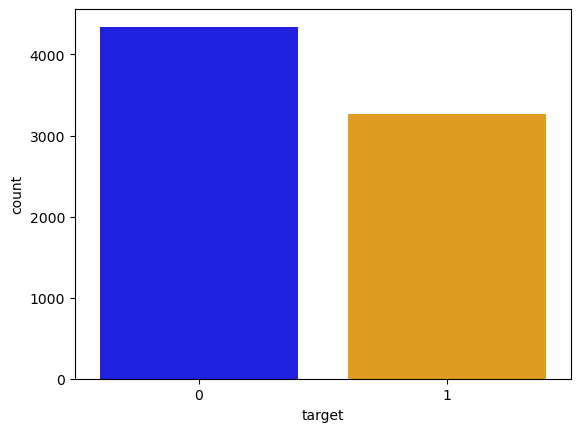

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

x = train['target'].value_counts()
print(x)

# Specifica manualmente i colori per ciascuna barra
colors = ['blue', 'orange']

sns.barplot(x=x.index, y=x, hue=x.index, palette=colors, legend=False)
plt.show()

In [4]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## 3.2 Number of words and characters

In [5]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
print(train[train['target']==1]['word_count'].mean()) #Disaster tweets
print(train[train['target']==0]['word_count'].mean()) #Non-Disaster tweets

15.167532864567411
14.704744357438969


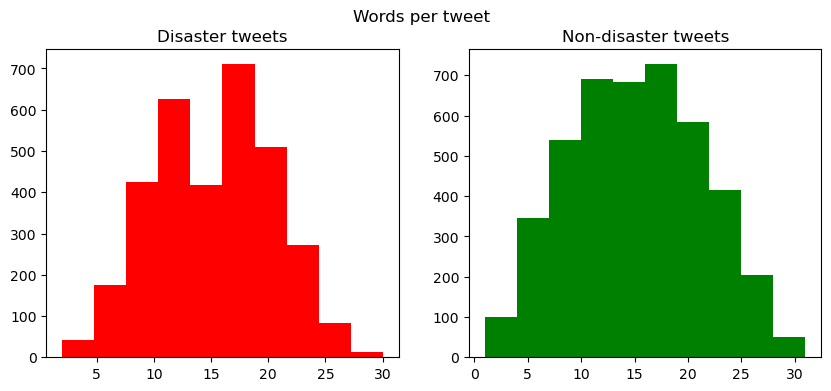

In [6]:
from matplotlib import pyplot as plt

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train[train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [7]:
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
print(train[train['target']==1]['char_count'].mean()) #Disaster tweets
print(train[train['target']==0]['char_count'].mean()) #Non-Disaster tweets

108.11342097217977
95.70681713496084


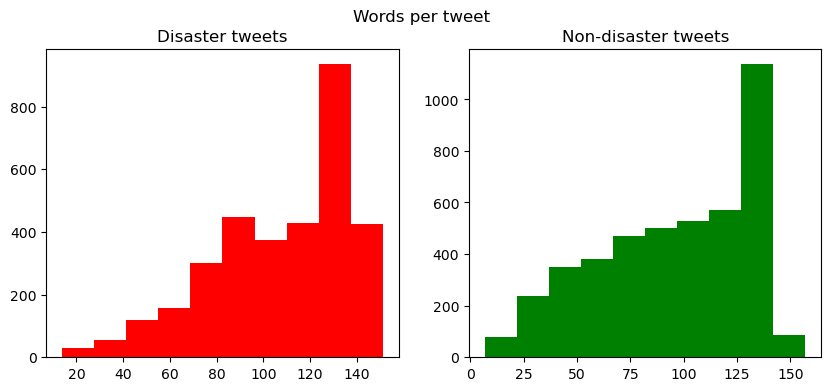

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train[train['target']==1]['char_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['char_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

# 4 Text pre-processing

we will apply the following operations:

- Lowercasing
- Entities, URL Links and Punctuation Removal
- Spelling Correction
- Lemmatization
- Stop Words Removal

## 4.1 Lowercasing

In [9]:
train["keyword"] = train["keyword"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train["clean_text"] = train["text"].apply(lambda x: str.lower(x))
train.sample(5)

,id,keyword,location,text,target,word_count,char_count,clean_text
3835,5458,first%20responders,"sacramento, ca",As firefighters make gains on #RockyFire Jerry...,1,20,122,as firefighters make gains on #rockyfire jerry...
1862,2676,crush,"bolivar, mo",When you're girlfriend is completely gorgeous?...,0,12,99,when you're girlfriend is completely gorgeous?...
4838,6885,mass%20murder,NaN,@JakeGint the mass murder got her hot and both...,1,17,96,@jakegint the mass murder got her hot and both...
1665,2406,collide,NaN,I liked a @YouTube video from @sqwizzix http:/...,0,19,133,i liked a @youtube video from @sqwizzix http:/...
4092,5817,hail,between dire and radiant,Hail! [pic] ÛÓ https://t.co/B7omJ7U3EI,0,4,39,hail! [pic] ûó https://t.co/b7omj7u3ei


## 4.2 URL links, Entities and Punctuation Removal

In [10]:
train["keyword"] = train["keyword"].apply(lambda x: re.sub(r'http\S+|www\S+','',x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: re.sub(r'http\S+|www\S+','',x) if pd.isna(x) != True else x)
train["clean_text"] = train["clean_text"].apply(lambda x: re.sub(r'http\S+|www\S+','',x))
train.sample(5)

,id,keyword,location,text,target,word_count,char_count,clean_text
4137,5884,hailstorm,"calgary, ab, canada",600 passengers abandoned at LRT station during...,1,13,113,600 passengers abandoned at lrt station during...
202,285,ambulance,NaN,http://t.co/X5YEUYLT1X Twelve feared killed in...,1,11,110,twelve feared killed in pakistani air ambulan...
1213,1750,buildings%20burning,in hell,Schools in Western Uganda still Burning down B...,1,16,121,schools in western uganda still burning down b...
5655,8067,rescue,sand springs oklahoma,Coastal German Shepherd Rescue OC shared a lin...,0,12,113,coastal german shepherd rescue oc shared a lin...
4714,6702,lava,probably watching survivor,The sunset looked like an erupting volcano ......,1,17,114,the sunset looked like an erupting volcano ......


In [11]:
import re, string

def remove_entities (text):
    entity_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, '')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
                if word[0] not in entity_prefixes:
                    words.append(word)
    return ' '.join(words)

In [12]:
train["keyword"] = train["keyword"].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
train["clean_text"] = train["clean_text"].apply(lambda x: remove_entities(x))
train.sample(5)

,id,keyword,location,text,target,word_count,char_count,clean_text
592,856,bioterror,us,FedEx no longer to transport bioterror germs i...,1,14,98,fedex no longer to transport bioterror germs i...
6307,9012,stretcher,florida,Homemade frozen yogurt pops? Have you had luck...,0,12,105,homemade frozen yogurt pops have you had luck ...
3645,5194,fatalities,san francisco,'Motordom' lobbied to change our language arou...,0,19,138,motordom lobbied to change our language around...
7088,10151,upheaval,london uk,Diageo's CEO stresses that a board revolt at U...,0,16,117,diageos ceo stresses that a board revolt at un...
5863,8375,ruin,winnipeg manitoba,Why do u ruin everything? @9tarbox u ruined t...,0,21,109,why do u ruin everything u ruined the sour cre...


## 4.2 Lemmatization

In [13]:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [14]:
train['keyword'] = train['keyword'].apply(lambda x: lemmatizer(x) if pd.isna(x) != True else x)
train['location'] = train['location'].apply(lambda x: lemmatizer(x) if pd.isna(x) != True else x)
train['clean_text'] = train['clean_text'].apply(lambda x: lemmatizer(x))
train.sample(5)

,id,keyword,location,text,target,word_count,char_count,clean_text
4432,6305,hostage,NaN,When u get mugged with ur gf u come up with th...,0,31,136,when u get mug with ur gf u come up with the b...
6875,9858,traumatise,london,Traumatised after seeing a baby literally fall...,0,20,110,traumatise after see a baby literally fall out...
6206,8856,smoke,NaN,In 2014 I will only smoke crqck if I becyme a ...,0,15,78,in 2014 i will only smoke crqck if i becyme a ...
5055,7204,natural20disaster,NaN,What Natural Disaster Are You When You Get Ang...,0,10,72,what natural disaster be you when you get angry
4903,6979,massacre,cimerak pangandaran,Review: Dude Bro Party Massacre III http://t.c...,0,13,113,review dude bro party massacre iii by patrick ...


## 4.3 Stop Word Removal

In [15]:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [16]:
train['keyword'] = train['keyword'].apply(lambda x: stopword(x) if pd.isna(x) != True else x)
train['clean_text'] = train['clean_text'].apply(lambda x: stopword(x) if pd.isna(x) != True else x)
train['clean_text'] = train['clean_text'].apply(lambda x: stopword(x))
train.sample(5)

,id,keyword,location,text,target,word_count,char_count,clean_text
4723,6716,lava,colombia,'I may have gotten a little too exited over my...,0,15,116,may get little exit home make lava lamp
2247,3217,deluge,up a hill,Also in a matter of weeks Amazon's going to be...,0,23,137,also matter week amazon go deluge poorly write...
654,946,blaze,raleigh durham nc,#breaking Firefighters battling blaze at east ...,1,10,88,firefighter battle blaze east cary condo building
988,1433,body20bagging,ìït 3998298875261624,@fuckyeahcarey @BornVerified drake killing thi...,1,15,96,drake kill dude tea bag dead body point
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...


# 5 Vectorization

As we saw in previous laboratories, it's difficult to work with text data. Indeed, we need to represent our text in fixed-size vectors. The process to convert text data into numerical data/vector, is called vectorization or in the NLP world, word embedding. Bag-of-Words(BoW) and Word Embedding (with Word2Vec) are two well-known methods for converting text data to numerical data.

## 5.1 Word2Vec

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train["clean_text"],train["target"],test_size=0.2,shuffle=True)

- **train["clean_text"]**: Questa è la feature (caratteristica) del dataset, contenente i testi puliti o tokenizzati che verranno utilizzati come input per il modello.

- **train["target"]**: Questa è l'etichetta associata a ciascun esempio nel dataset. L'etichetta di solito rappresenta la classe o la categoria a cui appartiene ciascun esempio.

- **test_size=0.2**: Indica che il 20% dei dati totali verrà utilizzato come set di test, mentre l'80% sarà utilizzato come set di addestramento.

- **shuffle=True**: Imposta che i dati vengano mescolati prima di essere suddivisi. La procedura di mescolamento (shuffle) delle voci durante la divisione del set di dati è importante per evitare che il modello di apprendimento automatico impari da pattern o ordini specifici nei dati di addestramento. Se non si mescolano le voci, potrebbero esserci delle sequenze o dei modelli nei dati che influenzano negativamente le prestazioni del modello.

Dopo l'esecuzione di questa riga di codice, X_train conterrà le features del set di addestramento, X_test conterrà le features del set di test, y_train conterrà le etichette del set di addestramento, e y_test conterrà le etichette del set di test.

In [18]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [19]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [20]:
# Tokenizzazione delle frasi presenti nel campo 'clean_text' del dataframe 'train'
train['clean_text_tok'] = [nltk.word_tokenize(i) for i in train['clean_text']]

# Creazione di un modello Word2Vec utilizzando le frasi tokenizzate
model = Word2Vec(train['clean_text_tok'], min_count=1)

# Creazione di un dizionario che mappa parole a vettori utilizzando il vocabolario del modello Word2Vec
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

# Creazione di un oggetto MeanEmbeddingVectorizer utilizzando il dizionario appena creato
modelw = MeanEmbeddingVectorizer(w2v)

# Trasformazione delle frasi di addestramento e test in vettori medi utilizzando il modello Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [21]:
print("Training w2v features shape:", X_train_vectors_w2v.shape)
print("Test w2v features shape:", X_test_vectors_w2v.shape)

Training w2v features shape: (6090, 100)
Test w2v features shape: (1523, 100)


In [22]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer(use_idf=True)

x_train_counts = count_vect.fit_transform(X_train)
X_train_vectors_tfidf = tfidf_transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(X_test)
X_test_vectors_tfidf = tfidf_transformer.transform(x_test_counts)

In [23]:
print("Training BoW features shape:", X_train_vectors_tfidf.shape)
print("Test BoW features shape:", X_test_vectors_tfidf.shape)

Training BoW features shape: (6090, 10840)
Test BoW features shape: (1523, 10840)


# 6 Classifier

## 6.1 K-NN with FAISS

Since we have text representation of our dataset, we are able to use this representation to perform text classification. In particular, we want to classify our tweets into two classes (binary classification): Disaster or No Distaster.

In [24]:
import faiss

In [25]:
import numpy as np 
#from collections import Counter
from scipy import stats

class FaissKNNImpl:
    
    def __init__(self,k,faiss):
        self.k = k # k nearest neighbor value
        self.faissIns = faiss # FAISS instance
        self.index = 0
        self.gpu_index_flat = 0 
        self.train_labels = []  
        self.test_label_faiss_output = [] 
        
    def fitModel(self,train_features,train_labels): 
        self.train_labels = train_labels
        self.index = self.faissIns.IndexFlatL2(train_features.shape[1])   # build the index 
        self.index.add(train_features)       # add vectors to the index
        
    def predict(self, test_features): 
        distance, test_features_faiss_Index = self.index.search(test_features, self.k) 
        nearest_labels = self.train_labels[test_features_faiss_Index.ravel()]
        self.test_label_faiss_output = np.array(stats.mode(nearest_labels.reshape(-1, self.k), axis=1)[0].ravel())
        return self.test_label_faiss_output
    
      
    def getAccuracy(self,test_labels):
        accuracy = (self.test_label_faiss_output == test_labels).mean() 
        return round(accuracy,2) 

In [26]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [27]:
import time 

k = 5
start_time = time.time()
faissobj = FaissKNNImpl(k,faiss)
faissobj.fitModel(X_train_vectors_w2v,y_train)
run_time = time.time() - start_time
print('time required for training %d data points at k = %d: %.2f seconds' % (X_train_vectors_w2v.shape[0], k , run_time))

time required for training 6090 data points at k = 5: 0.00 seconds


In [28]:
predictions = faissobj.predict(X_test_vectors_w2v)
run_time = time.time() - start_time
print('time required for predicting %d data point at k = %d: %.2f seconds' % (X_test_vectors_w2v.shape[0], k , run_time))

time required for predicting 1523 data point at k = 5: 0.14 seconds


In [29]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       859
           1       0.61      0.53      0.57       664

    accuracy                           0.65      1523
   macro avg       0.64      0.64      0.64      1523
weighted avg       0.65      0.65      0.65      1523



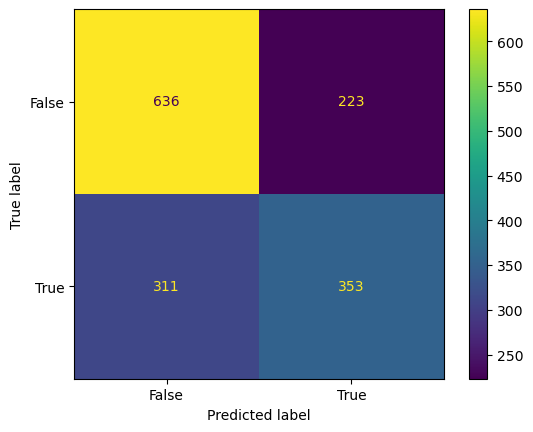

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt


confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [31]:
k = 5
start_time = time.time()
faissobj = FaissKNNImpl(k,faiss)
faissobj.fitModel(X_train_vectors_tfidf.todense(),y_train)
run_time = time.time() - start_time
print('time required for training %d data points at k = %d: %.2f seconds' % (X_train_vectors_tfidf.shape[0], k , run_time))

time required for training 6090 data points at k = 5: 0.27 seconds


In [32]:
predictions = faissobj.predict(X_test_vectors_tfidf.toarray())
run_time = time.time() - start_time
print('time required for predicting %d data point at k = %d: %.2f seconds' % (X_test_vectors_w2v.shape[0], k , run_time))

time required for predicting 1523 data point at k = 5: 7.43 seconds


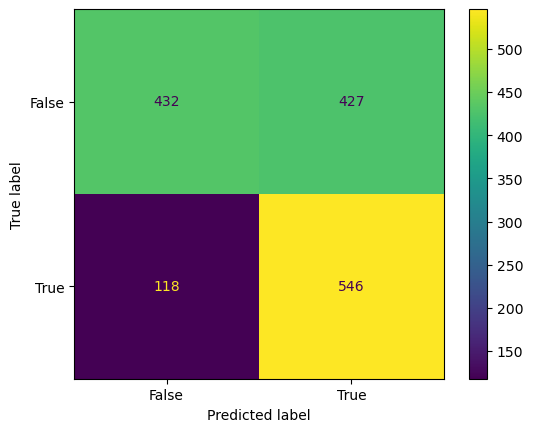

In [33]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [35]:
nb = MultinomialNB()
nb.fit(X_train_vectors_tfidf, y_train)

MultinomialNB()

In [37]:
predictions = nb.predict(X_test_vectors_tfidf)

In [38]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1012
           1       0.66      0.85      0.74       511

    accuracy                           0.80      1523
   macro avg       0.78      0.81      0.79      1523
weighted avg       0.83      0.80      0.80      1523



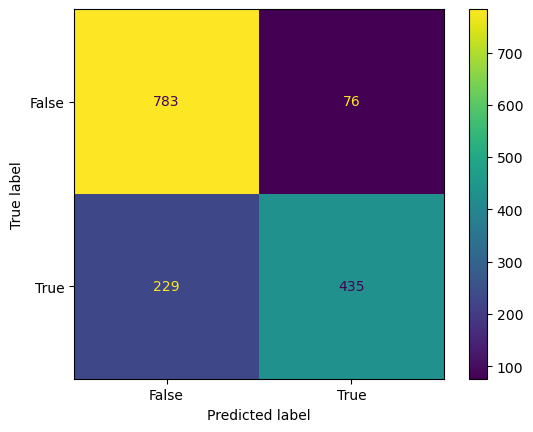

In [39]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()